In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from matplotlib.patches import Rectangle

from training import confusion_matrix_count
from dataloading import ShapesDataset
from model import ConvNeuralNet


C:\Users\16kin\anaconda3\envs\ml_base\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\16kin\anaconda3\envs\ml_base\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
np.random.seed(42)

batch_size = 16
dataset_name = 'Circ_WonB_many'
num_models = 4
model_save_freq = 50
report_freq = 10


csv_path = '../data/%s/%s_labels.csv'%(dataset_name, dataset_name)
len_dataset = len(pd.read_csv(csv_path))
train_size = 0 # int(0.7 * len_dataset)
val_size = 0 # int(0.1 * len_dataset)
test_size = len_dataset # int(0.2 * len_dataset)

print('lengths of \n Dataset: {}, Train: {}, Validation: {} ,Test: {}'.format(len_dataset,train_size,val_size,test_size))

dataset = ShapesDataset(csv_file = csv_path, nrows=None, device=device)

train_val_set,test_set =  torch.utils.data.random_split(dataset,[train_size+val_size,test_size])
train_set,val_set =  torch.utils.data.random_split(train_val_set,[train_size,val_size])

# train_loader = DataLoader(dataset = train_set,batch_size=16,shuffle = True)
# val_loader = DataLoader(dataset = val_set,batch_size=16,shuffle = True)
test_loader = DataLoader(dataset = test_set,batch_size=16,shuffle = True)

del train_set, train_val_set, val_set

print('Loaded!')

lengths of 
 Dataset: 10000, Train: 0, Validation: 0 ,Test: 10000
Loaded!


In [3]:
len(test_loader)

625

In [8]:
model_ds = 'Circ_WonB'
model_num = 'model2'
model_name = model_ds + '_' + model_num
model = torch.load('models/%s.pth'%(model_name))

max_shapes = 34

cm = confusion_matrix_count(model, test_loader)

In [9]:
max_pred = max([max(val) for val in cm.values()])
min_pred = min([min(val) for val in cm.values()])

top = max(max_shapes, max_pred)
bot = min(1, min_pred)

cmarr = np.zeros((max_shapes, top-bot+1))
for lab in range(max_shapes):
    for pred in range(top-bot+1):
        cmarr[lab][pred] = cm[lab+1][pred+bot]
        
acc = sum([cmarr[i][i-bot+1] for i in range(max_shapes)]) / np.sum(cmarr)
print('Accuracy:', acc)

cmarr_scaled = np.zeros((max_shapes, top-bot+1))
for lab in range(max_shapes):
    for pred in range(top-bot+1):
        cmarr_scaled[lab][pred] = cmarr[lab][pred] / sum(cmarr[lab])


Accuracy: 0.9037807561512302


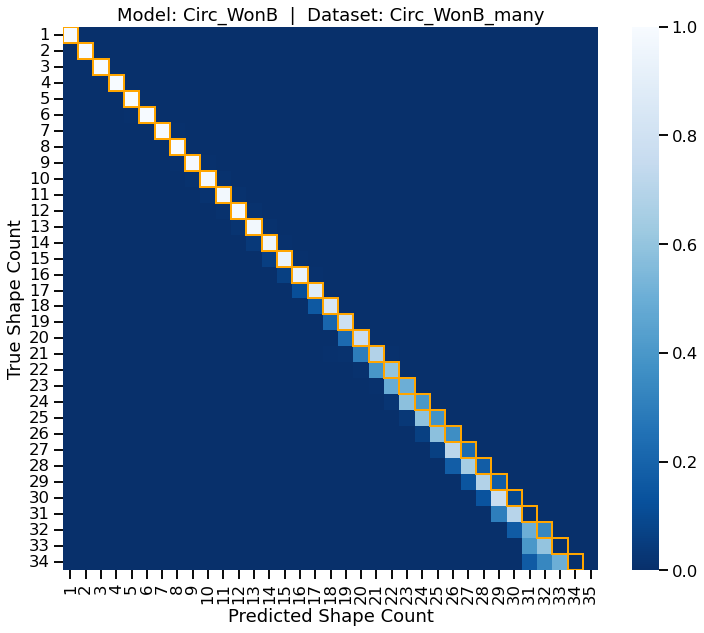

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(12,10))

x = sbn.heatmap(cmarr_scaled, xticklabels=range(bot, top+1), yticklabels=range(1,max_shapes+1), vmin=0.0, vmax=1.0, annot=False, cmap='Blues_r')

for i in range(max_shapes):
    x.axes.add_patch(Rectangle((i-bot+1, i), 1, 1, fill=False, edgecolor='orange', lw=2))

plt.title('Model: %s  |  Dataset: %s'%(model_ds, dataset_name))
plt.xlabel('Predicted Shape Count')
plt.ylabel('True Shape Count')

plt.show()
plt.savefig('../figures/HMtest-%s-%s.png'%(model_ds, dataset_name))

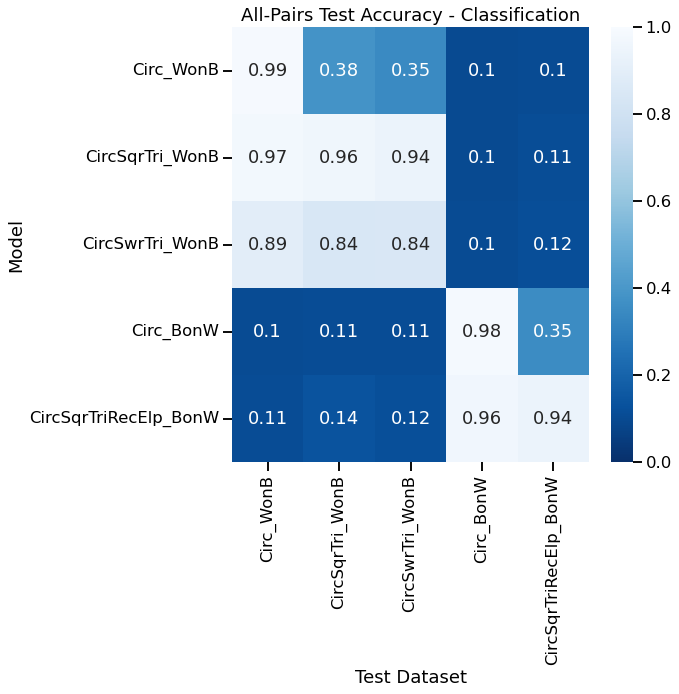

In [11]:
plt.figure(figsize=(8,8))
overall_data = [[0.9957, 0.4507, 0.4183, 0, 0.0029],
                [0.99, 0.9869, 0.9757, 0.0473, 0.0751],
                [0.9873, 0.9825, 0.9815, 0.1101, 0.1415],
                [0, 0.0003, 0.0004, 0.9929, 0.3236],
                [0.1068, 0.1415, 0.1224, 0.9824, 0.9763]]

overall_data_classification = [[0.9854, 0.3817, 0.346, 0.1004, 0.1032],
                               [0.973, 0.9576, 0.9409, 0.1005, 0.1128],
                               [0.8919, 0.8419, 0.8442, 0.1035, 0.117],
                               [0.1029, 0.1069, 0.1061, 0.9837, 0.3542],
                               [0.1078, 0.1354, 0.1192, 0.9635, 0.9411]]


dataset_names = ['Circ_WonB', 'CircSqrTri_WonB', 'CircSwrTri_WonB', 'Circ_BonW', 'CircSqrTriRecElp_BonW']

sbn.set_context('talk')
sbn.heatmap(overall_data_classification, xticklabels=dataset_names, yticklabels=dataset_names, vmin=0.0, vmax=1.0, annot=True, cmap='Blues_r')

plt.title('All-Pairs Test Accuracy - Classification')
plt.xlabel('Test Dataset')
plt.ylabel('Model')

plt.show()